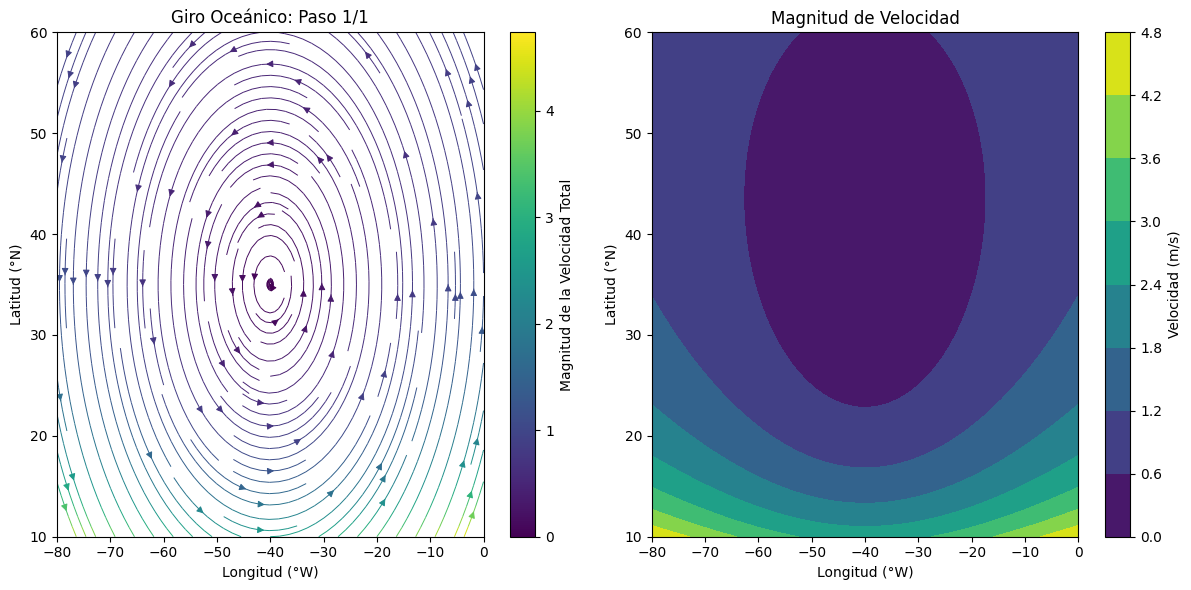

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Parámetros
rho = 1025  # Densidad del agua (kg/m^3)
Omega = 7.2921e-5  # Velocidad angular de la Tierra (rad/s)
P0 = 100  # Magnitud base del gradiente de presión
model = "linear"  # Modelo de gradiente: "exponential", "linear", "sinusoidal"
lat_scale = 35  # Escala para la dependencia en latitud
lon_scale = 40  # Escala para la dependencia en longitud
latitudes = np.linspace(10, 60, 100)  # 10°N a 60°N
longitudes = np.linspace(-80, 0, 100)  # 80°W a 0°
Longitudes, Latitudes = np.meshgrid(longitudes, latitudes)
deg2m = 111000  # Aprox. 1 grado = 111 km
profundidad=1000


def calculate_pressure_gradient(Longitudes, Latitudes, P0, model="linear", lat_scale=40, lon_scale=20):
    
    if model == "exponential":
        grad_P_y = -P0 * np.exp(-(Latitudes - lat_scale) / (lat_scale * deg2m))
        grad_P_x = P0 * np.exp(-(Longitudes + lon_scale) / (lon_scale * deg2m))
    elif model == "linear":
        grad_P_y = -deg2m*P0 * (Latitudes - lat_scale) / (lat_scale * deg2m)
        grad_P_x = deg2m*P0 * (Longitudes + lon_scale) / (lon_scale * deg2m)
    elif model == "sinusoidal":
        grad_P_y = -P0 * np.sin(np.deg2rad(Latitudes / (lat_scale * deg2m)))
        grad_P_x = P0 * np.cos(np.deg2rad(Longitudes / (lon_scale * deg2m)))
    else:
        raise ValueError(f"Modelo de presión '{model}' no reconocido.")
    
    return grad_P_x, grad_P_y


# Frecuencia de Coriolis
f = 2 * Omega * np.sin(np.deg2rad(Latitudes))

# Viento 
U = -10 * np.ones(Longitudes.shape)  
V = np.zeros(Longitudes.shape)       

# Esfuerzo del viento
Cd = 1.2e-3  
tau_x = Cd * U**2 * np.sign(U)
tau_y = Cd * V**2 * np.sign(V)
  

# Inicialización de la temperatura y densidad
temperature = 15 * np.ones_like(Longitudes)
density = 33 * np.ones_like(Longitudes)  

# Simulación temporal
steps = 1  
for step in range(steps):
    # Transporte de Ekman (debido al viento y Coriolis)
    Q_x_ekman = tau_y / (f * rho)  
    Q_y_ekman = -tau_x / (f * rho)  

    # Cálculo del gradiente de presión
    grad_P_x, grad_P_y = calculate_pressure_gradient(Longitudes, Latitudes, P0, model=model, 
                                                      lat_scale=lat_scale, lon_scale=lon_scale)
    
    # Transporte debido al gradiente de presión
    Q_x_pressure = grad_P_y / (rho * f)
    Q_y_pressure = grad_P_x / (rho * f)

    # Transporte total (Ekman + Gradiente de presión)
    v_x_total = (Q_x_ekman + Q_x_pressure)/profundidad
    v_y_total = (Q_y_ekman + Q_y_pressure)/profundidad


    # Centro del giro
    centro_lon = -40
    centro_lat = 35

    r_i = np.sqrt((Longitudes - centro_lon)**2 + (Latitudes - centro_lat)**2) * deg2m 
    
    l_i=np.sqrt((0.5**2 + 0.8**2)) * deg2m
    
    velocidad_magnitud = np.sqrt(v_x_total**2 + v_y_total**2)

    # Disipación local P_i en cada celda
    P_i = velocidad_magnitud * l_i

    # Visualización
    plt.figure(figsize=(18, 6))

    
    plt.subplot(1, 3, 1)
    speed = np.sqrt(v_x_total**2 + v_y_total**2) 
    vmin, vmax = 0, np.max(speed)

    strm=plt.streamplot(Longitudes, Latitudes, v_x_total, v_y_total, color=speed,
                   cmap="viridis", density=1.5, linewidth=0.7, arrowsize=1,
                   )
    strm.lines.set_clim(vmin, vmax)
    plt.colorbar(label="Magnitud de la Velocidad Total")
    plt.title(f"Giro Oceánico: Paso {step+1}/{steps}")
    plt.xlabel("Longitud (°W)")
    plt.ylabel("Latitud (°N)")

    plt.subplot(1, 3, 2)
    speed = np.sqrt(v_x_total**2 + v_y_total**2)
    plt.contourf(Longitudes, Latitudes, speed, cmap="viridis")
    plt.colorbar(label="Velocidad (m/s)")
    plt.title(f"Magnitud de Velocidad")
    plt.xlabel("Longitud (°W)")
    plt.ylabel("Latitud (°N)")

    # Mostrar los gráficos
    plt.tight_layout()
    plt.show()

    # Guardar la matriz P_i
    np.save("C:\\Users\\Ana\\Desktop\\Python TFG\\Pi_sin1.npy", P_i)